In [1]:
import pandas as pd
import numpy as np

np.random.seed(1)

In [2]:
dateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d")
seaLvl = pd.read_csv('sea_levels_2015.csv', header = 0, parse_dates = ['Time'], date_parser = dateparser)
seaLvl['Year'] = seaLvl['Time'].apply(lambda x: x.year)
seaLvl['Month'] = seaLvl['Time'].apply(lambda x: x.month)
seaLvl = seaLvl.drop(['Time'], axis = 1)

seaLvl.head()

<ipython-input-2-b01a6b46929d>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d")


,GMSL,GMSL uncertainty,Year,Month
0,-183.0,24.2,1880,1
1,-171.1,24.2,1880,2
2,-164.3,24.2,1880,3
3,-158.2,24.2,1880,4
4,-158.7,24.2,1880,5


In [3]:
seaIce = pd.read_csv('seaice.csv')
seaIce.columns = [x.strip() for x in list(seaIce.columns)]

grp = seaIce.groupby(['Year', 'Month'])
seaIce = grp.agg("mean").reset_index()
seaIce.drop(columns=['Day', 'Missing'], inplace = True)

seaIce.head()

,Year,Month,Extent
0,1978,10,14.050833
1,1978,11,13.770767
2,1978,12,12.031156
3,1979,1,10.408100
4,1979,2,9.658179


In [4]:
temp = pd.read_csv('GlobalTemperatures.csv', header = 0, parse_dates = ['dt'], date_parser = dateparser)
temp['Year'] = temp['dt'].apply(lambda x: x.year)
temp['Month'] = temp['dt'].apply(lambda x: x.month)
temp = temp[['Year', 'Month', 'LandAverageTemperature']]

temp.head()

<ipython-input-2-b01a6b46929d>:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d")


,Year,Month,LandAverageTemperature
0,1750,1,3.034
1,1750,2,3.083
2,1750,3,5.626
3,1750,4,8.490
4,1750,5,11.573


In [5]:
data = seaLvl.merge(seaIce, how = 'inner').merge(temp, how = 'inner')

In [6]:
data.head()

,GMSL,GMSL uncertainty,Year,Month,Extent,LandAverageTemperature
0,-17.7,6.7,1978,10,14.050833,9.339
1,-22.2,6.7,1978,11,13.770767,6.350
2,-25.2,6.7,1978,12,12.031156,3.740
3,-28.0,6.7,1979,1,10.408100,2.679
4,-26.9,6.7,1979,2,9.658179,2.841


In [7]:
def normalize(d):
    return (np.array(d) - np.mean(np.array(d)))/np.std(np.array(d))

In [8]:
data['GMSL'] = normalize(data['GMSL'])
data['Extent'] = normalize(data['Extent'])
data['LandAverageTemperature'] = normalize(data['LandAverageTemperature'])

In [9]:
y = data['GMSL'][1:].values
x = data[['GMSL','Extent','LandAverageTemperature']].iloc[:-1,:].values

In [10]:
x.shape, y.shape

((422, 3), (422,))

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 10)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((337, 3), (85, 3), (337,), (85,))

In [14]:
D = 3
M = 2
K = 1
W1 = np.random.randn(D, M)
b1 = np.random.randn(M)
W2 = np.random.randn(M, K)
b2 = np.random.randn(K)
learning_rate = 0.002

def sigmoid(a):
    return 1 / (1 + np.exp(-a))

def forward(X, W1, b1, W2, b2):
    
    Z = sigmoid(X.dot(W1) + b1)
    A = Z.dot(W2) + b2
    A = np.array([x for l in A for x in l])
    
    return Z, A


def cost(y_true, y_est):
    return (0.5*(y_true - y_est)**2).sum()


def derivative_W2(Z, T, Y):
    
    v = Z.T.dot(T - Y).reshape(-1,1)
    
#     n = T.shape[0]
#     v = np.zeros((M,K))
#     for t in range(n):
#         for h in range(M):
#             v[h, 0] += (np.array(T)[t] - Y[t])*Z[t,h]
            
    return v


def derivative_b2(T, Y):
    
    return (T - Y).sum()


def derivative_W1(X, Z, T, Y, W2):
    
    n = X.shape[0]
    
#     w = np.zeros((D, M))
#     for t in range(n):
#         for h in range(M):
#             for j in range(D):
#                 w[j, h] += (np.array(T)[t] - Y[t])*W2[h,0]*Z[t,h]*(1-Z[t,h])*X[t,j]
        
    w = X.T.dot((T - Y).reshape(-1,1).dot(W2.T) * Z * (1 - Z))
    
    return w

def derivative_b1(Z, T, Y, W2):
    
    return ((T - Y).reshape(-1,1).dot(W2.T) * Z * (1 - Z)).sum(axis=0)

Trained variables:
W1: 
 [[ 0.99004708 -1.43738513]
 [-0.08174356 -0.29699553]
 [-0.1843202  -0.80666028]]
b1: 
 [-0.43915577  0.13760539]
W2: 
 [[ 3.58226332]
 [-0.97834471]]
b2: 
 [-0.9220208]


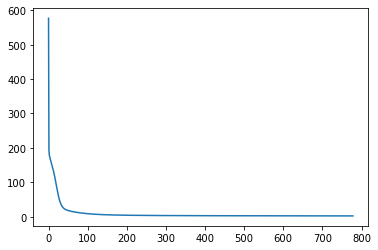

In [15]:
import matplotlib.pyplot as plt
err_threshold = 2

costs = []
for epoch in range(1000):
    hidden, output = forward(X_train, W1, b1, W2, b2)
    costs.append(cost(y_train, output))
    
    if cost(y_train, output) < err_threshold:
        print('Trained variables:')
        print('W1: \n', W1)
        print('b1: \n', b1)
        print('W2: \n', W2)
        print('b2: \n', b2)
        break
        
    W2 += learning_rate * derivative_W2(hidden, y_train, output)
    b2 += learning_rate * derivative_b2(y_train, output)
    W1 += learning_rate * derivative_W1(X_train, hidden, y_train, output, W2)
    b1 += learning_rate * derivative_b1(hidden, y_train, output, W2)
    
    
plt.plot(costs)
plt.show()

In [16]:
costs

[576.8852563997992,
 195.3741770672072,
 178.6906292133229,
 173.54755612181486,
 169.16313069195854,
 164.98341854540897,
 160.91917600811053,
 156.90002474382177,
 152.86618546662072,
 148.76466858670386,
 144.5481787159962,
 140.17467675759116,
 135.60769023962314,
 130.81735608039764,
 125.78215344420599,
 120.49120647819754,
 114.9468903820786,
 109.1672904160116,
 103.1878945074757,
 97.06183553517079,
 90.85812966359168,
 84.65771870388909,
 78.54764817997585,
 72.61422472044268,
 66.9362926571888,
 61.57972722349337,
 56.59388860653242,
 52.01027471638854,
 47.84314340660646,
 44.09157889444807,
 40.742384151244124,
 37.773244880287336,
 35.15575564288233,
 32.8580588727511,
 30.846983418720562,
 29.089666156501586,
 27.55469922748151,
 26.212874755317852,
 25.037607938087245,
 24.005116287677318,
 23.094423372853292,
 22.28724357207779,
 21.567792354565828,
 20.922555708605696,
 20.340043064549768,
 19.810540545650728,
 19.325875526178613,
 18.879199076279335,
 18.464789681220

In [76]:
x = list(data['GMSL'])

def input_generator_2D(seq, n):
    
    input_x = list()
    input_y = list()

    for i in range(len(seq)-n):

        input_x.append(seq[i:i+n])
        input_y.append(seq[i+n])
        
    return np.array(input_x), np.array(input_y)

In [77]:
x, y = input_generator_2D(x, 3)
print(x)
print(y)

[[-17.7 -22.2 -25.2]
 [-22.2 -25.2 -28. ]
 [-25.2 -28.  -26.9]
 ...
 [ 71.2  71.6  68.8]
 [ 71.6  68.8  66.4]
 [ 68.8  66.4  59.7]]
[-28.  -26.9 -25.8 -26.1 -27.5 -27.1 -24.7 -19.9 -17.3 -14.9 -17.2 -15.
 -15.2 -14.1 -16.1 -15.8 -16.1 -16.7 -19.2 -21.  -21.  -19.2 -14.   -9.9
  -7.8  -6.8  -5.   -4.   -2.7  -2.2  -3.9  -3.1  -4.1  -2.   -2.9  -4.4
  -8.2  -9.3 -10.6 -13.1 -13.5 -14.7 -15.8 -14.4 -10.3  -4.7  -2.1  -1.6
   0.2  -0.5   1.1   4.3   7.5   6.    1.8  -5.9  -6.7  -9.7  -6.8  -8.9
  -7.5  -6.3  -3.   -2.2  -1.2   1.    0.6   2.   -0.2  -1.1  -4.4  -6.4
 -10.4  -9.5 -11.7 -11.7 -13.5 -13.1 -13.7 -15.4 -14.6 -13.9 -12.5 -12.2
 -10.8  -9.7 -10.3 -10.5 -11.8 -11.  -13.3 -12.5 -13.5 -13.9 -14.3 -13.1
 -11.2  -8.5 -10.8 -12.4 -10.9  -9.3  -8.2 -13.5 -15.3 -16.7 -12.1  -8.6
  -9.1  -7.8  -9.9  -8.2  -8.1  -6.6  -6.4  -4.8  -3.3  -2.6  -4.9  -9.4
  -9.4  -8.   -2.4  -1.6  -1.1  -3.   -2.7  -1.    0.3   0.6   1.1  -0.6
  -0.2  -2.6  -4.4  -3.9  -4.1  -0.   -0.2   2.8   3.    3.8   4.3

In [78]:
x = np.array(list(map(list, zip(data['GMSL'], data['Extent'], data['LandAverageTemperature']))))

In [79]:
def input_generator_3D(seq, n):
    
    input_x = list()
    input_y = list()

    for i in range(len(seq)-n):

        input_x.append(seq[i:i+n, :])
        input_y.append(seq[i+n, 0])

    return np.array(input_x), np.array(input_y)

In [80]:
x, y = input_generator_3D(x, 3)

In [81]:
x

array([[[-17.7       ,  14.05083333,   9.339     ],
        [-22.2       ,  13.77076667,   6.35      ],
        [-25.2       ,  12.03115625,   3.74      ]],

       [[-22.2       ,  13.77076667,   6.35      ],
        [-25.2       ,  12.03115625,   3.74      ],
        [-28.        ,  10.4081    ,   2.679     ]],

       [[-25.2       ,  12.03115625,   3.74      ],
        [-28.        ,  10.4081    ,   2.679     ],
        [-26.9       ,   9.65817857,   2.841     ]],

       ...,

       [[ 71.2       ,  12.4701129 ,  15.003     ],
        [ 71.6       ,  12.33864516,  14.742     ],
        [ 68.8       ,  12.29846667,  13.154     ]],

       [[ 71.6       ,  12.33864516,  14.742     ],
        [ 68.8       ,  12.29846667,  13.154     ],
        [ 66.4       ,  13.23630645,  10.256     ]],

       [[ 68.8       ,  12.29846667,  13.154     ],
        [ 66.4       ,  13.23630645,  10.256     ],
        [ 59.7       ,  13.4056    ,   7.424     ]]])

In [82]:
y

array([-28. , -26.9, -25.8, -26.1, -27.5, -27.1, -24.7, -19.9, -17.3,
       -14.9, -17.2, -15. , -15.2, -14.1, -16.1, -15.8, -16.1, -16.7,
       -19.2, -21. , -21. , -19.2, -14. ,  -9.9,  -7.8,  -6.8,  -5. ,
        -4. ,  -2.7,  -2.2,  -3.9,  -3.1,  -4.1,  -2. ,  -2.9,  -4.4,
        -8.2,  -9.3, -10.6, -13.1, -13.5, -14.7, -15.8, -14.4, -10.3,
        -4.7,  -2.1,  -1.6,   0.2,  -0.5,   1.1,   4.3,   7.5,   6. ,
         1.8,  -5.9,  -6.7,  -9.7,  -6.8,  -8.9,  -7.5,  -6.3,  -3. ,
        -2.2,  -1.2,   1. ,   0.6,   2. ,  -0.2,  -1.1,  -4.4,  -6.4,
       -10.4,  -9.5, -11.7, -11.7, -13.5, -13.1, -13.7, -15.4, -14.6,
       -13.9, -12.5, -12.2, -10.8,  -9.7, -10.3, -10.5, -11.8, -11. ,
       -13.3, -12.5, -13.5, -13.9, -14.3, -13.1, -11.2,  -8.5, -10.8,
       -12.4, -10.9,  -9.3,  -8.2, -13.5, -15.3, -16.7, -12.1,  -8.6,
        -9.1,  -7.8,  -9.9,  -8.2,  -8.1,  -6.6,  -6.4,  -4.8,  -3.3,
        -2.6,  -4.9,  -9.4,  -9.4,  -8. ,  -2.4,  -1.6,  -1.1,  -3. ,
        -2.7,  -1. ,